# Bike sharing demand

https://www.kaggle.com/competitions/bike-sharing-demand

날짜별로 매 시간대에 count를 예측, 평가는 RMSE로 해야 함.

In [5]:
import os
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
plt.style.use('seaborn')
sns.set(font_scale=2.5)

## 데이터 로드 및 데이터 살펴보기

- train 및 test 데이터 로드 및 기본 데이터 확인
- 데이터 속성
  * datetime - hourly date + timestamp  
  * season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
  * holiday - whether the day is considered a holiday
  * workingday - whether the day is neither a weekend nor holiday
  * weather
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
  * temp - temperature in Celsius
  * atemp - "feels like" temperature in Celsius (체감온도)
  * humidity - relative humidity (습도)
  * windspeed - wind speed
  * casual - number of non-registered user rentals initiated
  * registered - number of registered user rentals initiated
  * count - number of total rentals

In [7]:
file_path = os.path.join(os.path.abspath("."), *['data'])

file_path

'/Users/jmac/project/kaggle/bike_sharing_demand/data'

In [9]:
train_pdf = pd.read_csv(os.path.join(file_path, 'train.csv'))

train_pdf.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


In [11]:
test_pdf = pd.read_csv(os.path.join(file_path, 'test.csv'))
test_pdf.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981
6492,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981


train과 test 데이터 간의 column 차이가 있음을 확인함.
- test에 없는 casual과 registered 데이터가 있음.
- 따라서 train 데이터 재정비가 필요.

In [12]:
(set(train_pdf.columns)-{'count'}) - set(test_pdf.columns)

{'casual', 'registered'}

In [13]:
re_cols = set(train_pdf.columns) - ((set(train_pdf.columns)-{'count'}) - set(test_pdf.columns))

In [14]:
train_pdf2 = train_pdf[list(re_cols)].copy()

In [15]:
train_pdf2.tail()

,windspeed,workingday,temp,count,weather,atemp,holiday,datetime,season,humidity
10881,26.0027,1,15.58,336,1,19.695,0,2012-12-19 19:00:00,4,50
10882,15.0013,1,14.76,241,1,17.425,0,2012-12-19 20:00:00,4,57
10883,15.0013,1,13.94,168,1,15.910,0,2012-12-19 21:00:00,4,61
10884,6.0032,1,13.94,129,1,17.425,0,2012-12-19 22:00:00,4,61
10885,8.9981,1,13.12,88,1,16.665,0,2012-12-19 23:00:00,4,66


null 값 확인 -> 없음

In [26]:
train_pdf2.isnull().sum()

windspeed     0
datetime      0
atemp         0
season        0
humidity      0
temp          0
weather       0
workingday    0
holiday       0
count         0
dtype: int64

In [27]:
test_pdf.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

데이터 타입 확인
- datetime 부분을 형변환 시켜주기

In [29]:
train_pdf2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   windspeed   10886 non-null  float64
 1   datetime    10886 non-null  object 
 2   atemp       10886 non-null  float64
 3   season      10886 non-null  int64  
 4   humidity    10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   weather     10886 non-null  int64  
 7   workingday  10886 non-null  int64  
 8   holiday     10886 non-null  int64  
 9   count       10886 non-null  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 850.6+ KB


In [33]:
train_pdf2['datetime'] = pd.to_datetime(train_pdf2['datetime'])
train_pdf2['year'] = train_pdf2.datetime.dt.year
train_pdf2['month'] = train_pdf2.datetime.dt.month
train_pdf2['day'] = train_pdf2.datetime.dt.day
train_pdf2['hour'] = train_pdf2.datetime.dt.hour

train_pdf2.tail()

,windspeed,datetime,atemp,season,humidity,temp,weather,workingday,holiday,count,year,month,day,hour
10881,26.0027,2012-12-19 19:00:00,19.695,4,50,15.58,1,1,0,336,2012,12,19,19
10882,15.0013,2012-12-19 20:00:00,17.425,4,57,14.76,1,1,0,241,2012,12,19,20
10883,15.0013,2012-12-19 21:00:00,15.910,4,61,13.94,1,1,0,168,2012,12,19,21
10884,6.0032,2012-12-19 22:00:00,17.425,4,61,13.94,1,1,0,129,2012,12,19,22
10885,8.9981,2012-12-19 23:00:00,16.665,4,66,13.12,1,1,0,88,2012,12,19,23


## 그래프로 데이터 확인

### 시간에 따른 대여량 확인
- year: 2011보다 2012년도에 대여량임 많음
- month: 여름에 대여량이 더 많음
- day : 별 차이가 없음
- hour: 출퇴근 시간대에 차이가 남

<AxesSubplot:xlabel='hour', ylabel='count'>

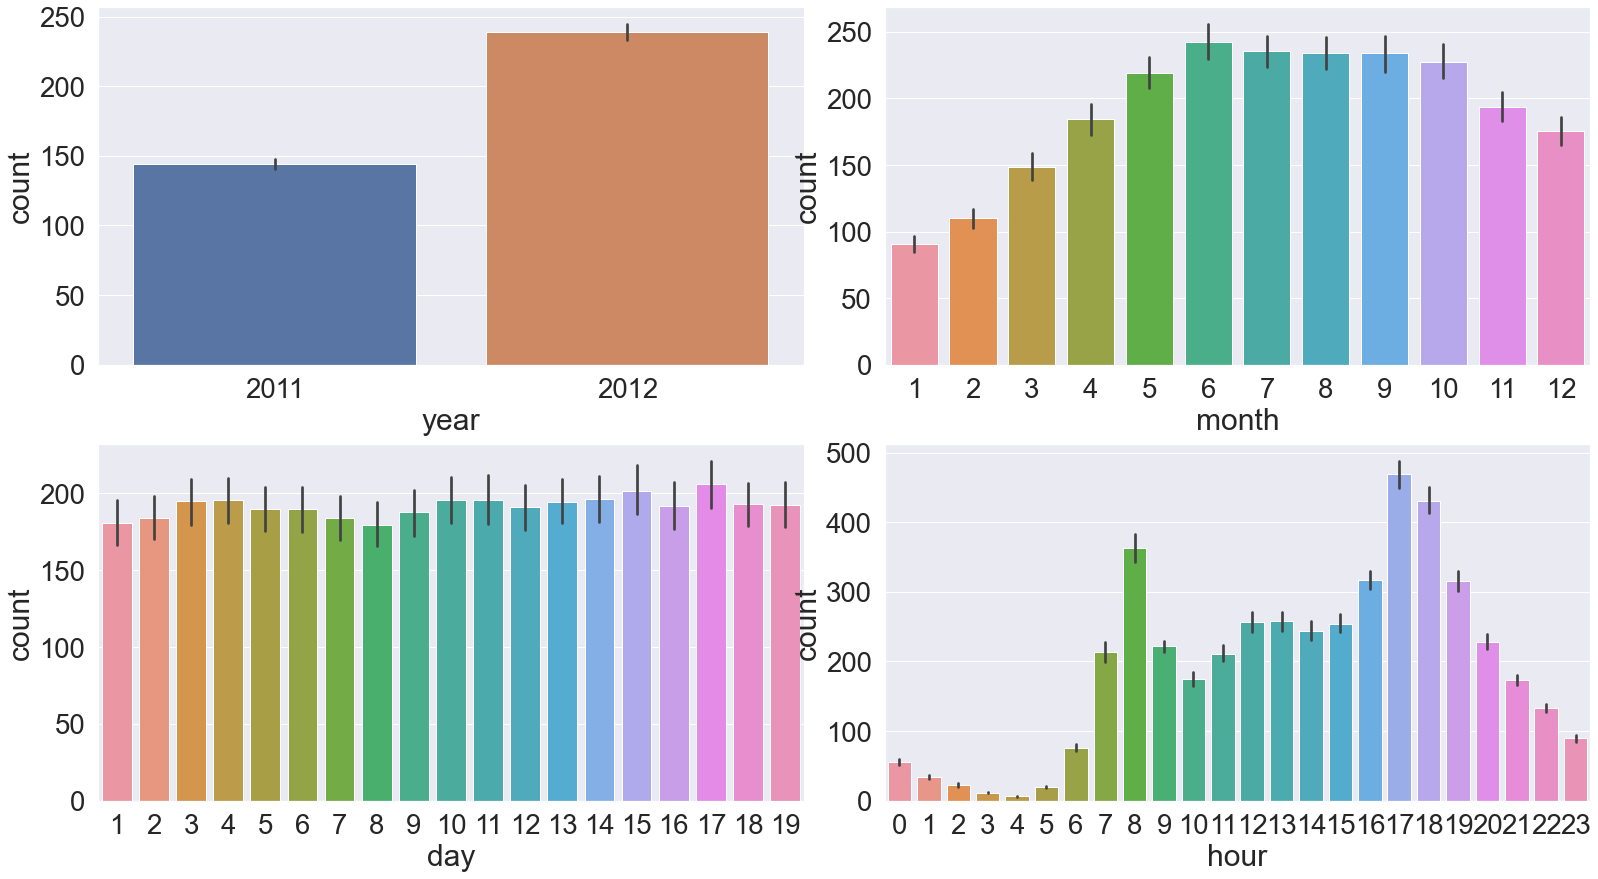

In [40]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(22,12))
fig.tight_layout(h_pad=3)

sns.barplot(data=train_pdf2, x='year', y='count', ax=ax[0][0])
sns.barplot(data=train_pdf2, x='month', y='count', ax=ax[0][1])
sns.barplot(data=train_pdf2, x='day', y='count', ax=ax[1][0])
sns.barplot(data=train_pdf2, x='hour', y='count', ax=ax[1][1])


### 시간에 따른 대여량 평균 분포 확인

<AxesSubplot:xlabel='hour', ylabel='count'>

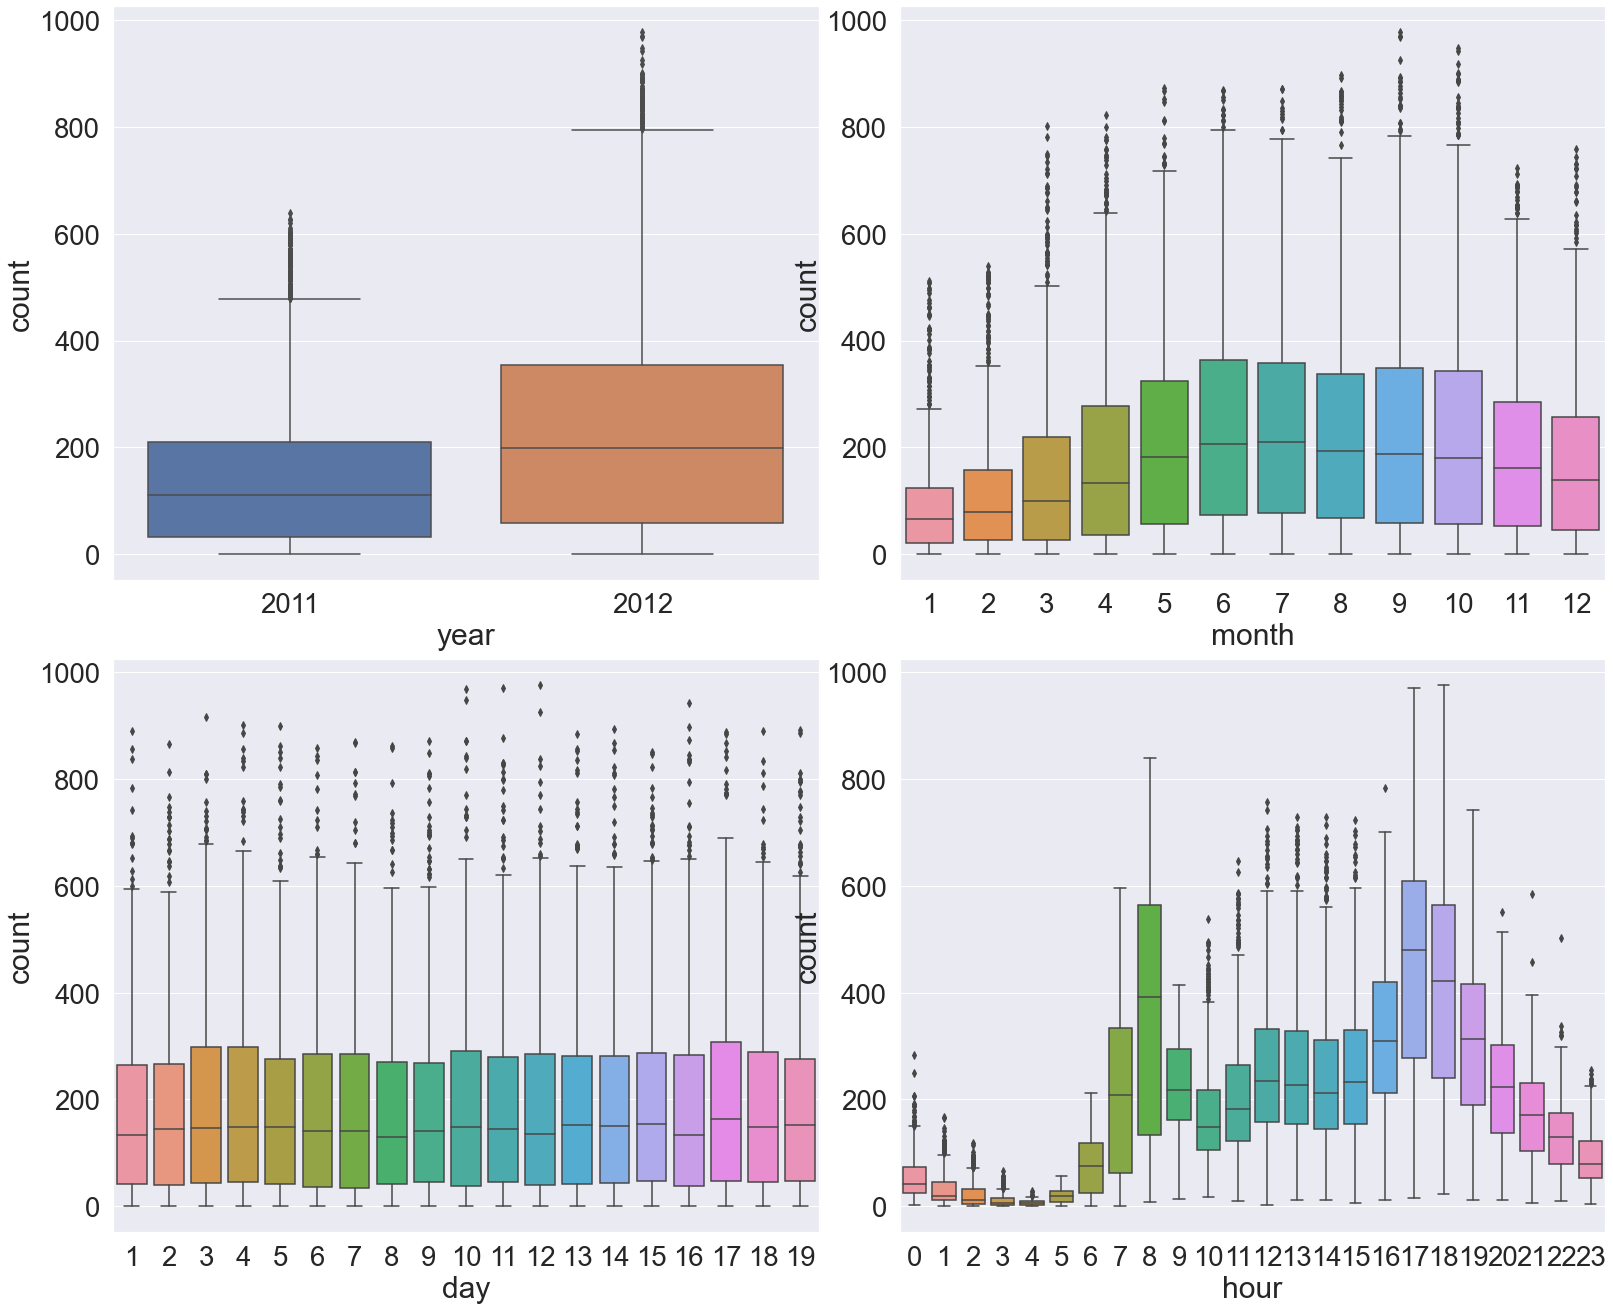

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(22,18))
fig.tight_layout(h_pad=3)

sns.boxplot(data=train_pdf2, x='year', y='count', ax=ax[0][0])
sns.boxplot(data=train_pdf2, x='month', y='count', ax=ax[0][1])
sns.boxplot(data=train_pdf2, x='day', y='count', ax=ax[1][0])
sns.boxplot(data=train_pdf2, x='hour', y='count', ax=ax[1][1])

### 시간에 따른 그 외 데이터 확인
- season: 4(winter)에는 상대적으로 조금 덜 이용하는 경향이 있음
- weather: 4(Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog)에는 날씨가 안좋아서 이용을 거의 안함
- holiday: 0(non-holiday)에는 workingday와 동일한 패턴이 나옴
- workingday: 1(workingday)는 holiday(0, non-holiday) 와 동일한 데이터 패턴이 나옴.

즉, weather가 아주 심한날 제외하고는 일정하게 시간대별로 출/퇴근 시간대에 많이 사용하며, 이것은 workingday만 유효함. (휴일은 둥글게 분포됨)

<AxesSubplot:xlabel='hour', ylabel='count'>

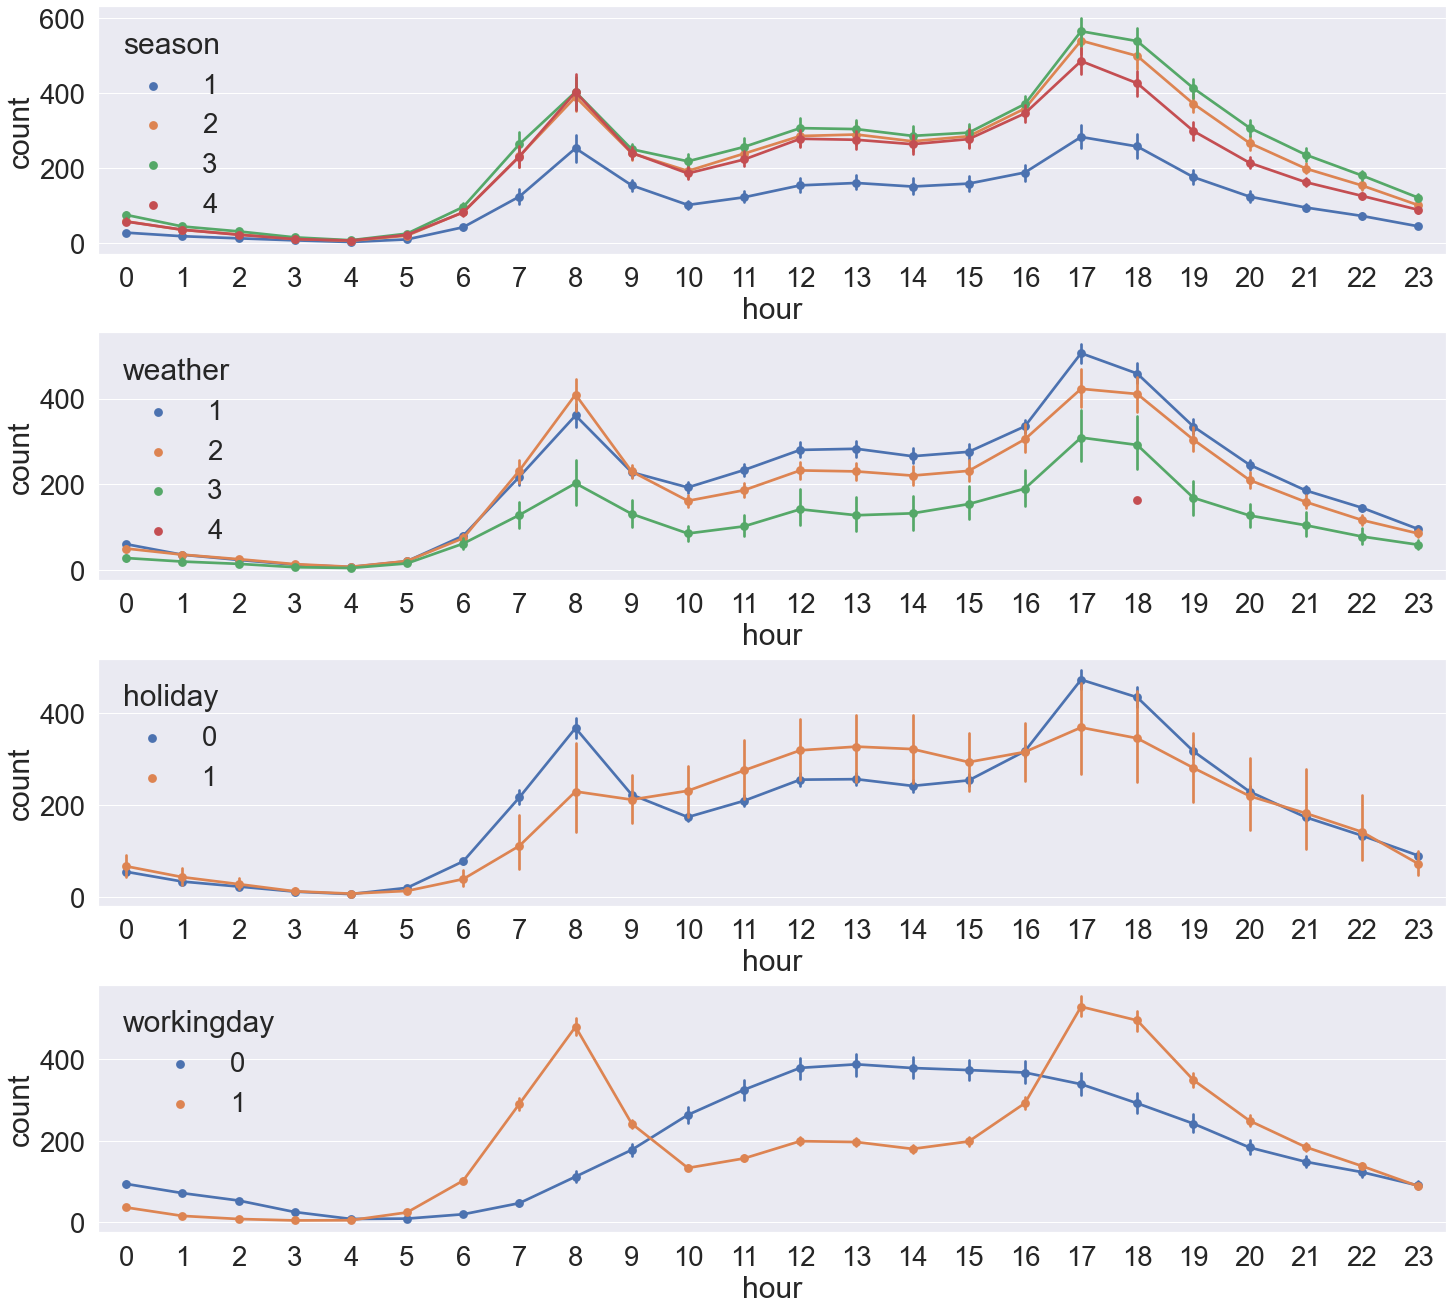

In [50]:
fig, ax = plt.subplots(nrows=4,figsize=(20,18))
fig.tight_layout(h_pad=3)

sns.pointplot(data=train_pdf2, x='hour', y='count', hue='season', ax=ax[0])
sns.pointplot(data=train_pdf2, x='hour', y='count', hue='weather', ax=ax[1])
sns.pointplot(data=train_pdf2, x='hour', y='count', hue='holiday', ax=ax[2])
sns.pointplot(data=train_pdf2, x='hour', y='count', hue='workingday', ax=ax[3])

참고로, 요일별로도 한번 확인해볼까?

- 5,6은 토/일을 의미하므로 workingday와 다르게 holiday의 특성을 띄고 있음

In [54]:
train_pdf2['day_of_week'] = train_pdf2['datetime'].dt.day_of_week
train_pdf2.tail()

,windspeed,datetime,atemp,season,humidity,temp,weather,workingday,holiday,count,year,month,day,hour,day_of_week
10881,26.0027,2012-12-19 19:00:00,19.695,4,50,15.58,1,1,0,336,2012,12,19,19,2
10882,15.0013,2012-12-19 20:00:00,17.425,4,57,14.76,1,1,0,241,2012,12,19,20,2
10883,15.0013,2012-12-19 21:00:00,15.910,4,61,13.94,1,1,0,168,2012,12,19,21,2
10884,6.0032,2012-12-19 22:00:00,17.425,4,61,13.94,1,1,0,129,2012,12,19,22,2
10885,8.9981,2012-12-19 23:00:00,16.665,4,66,13.12,1,1,0,88,2012,12,19,23,2


<AxesSubplot:xlabel='hour', ylabel='count'>

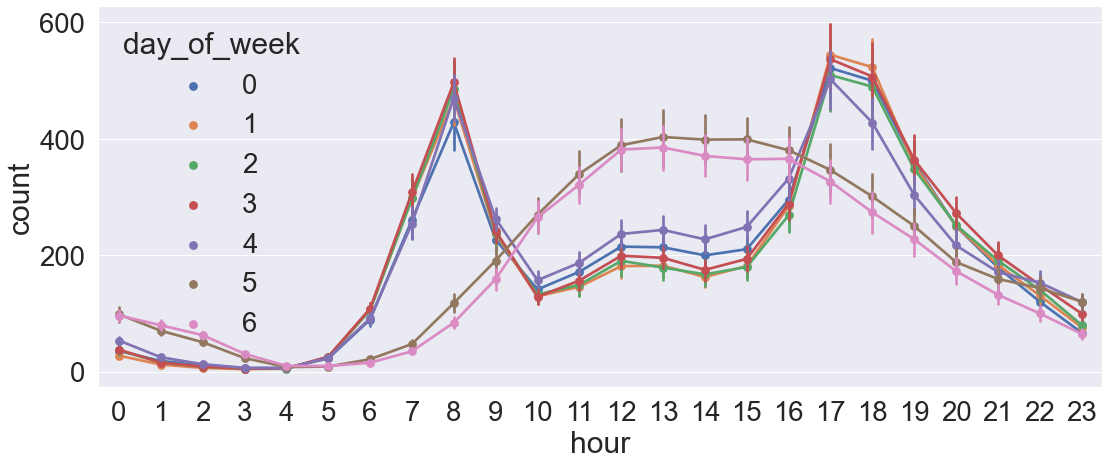

In [62]:
fig, ax = plt.subplots(figsize=(18,7))
# print(ax)
sns.pointplot(data=train_pdf2, x='hour', y='count', hue='day_of_week', ax=ax)

### Numeric 데이터 확인
- temp: 일정함
- atemp: 일정함
- humidity: min-25%간에 차이가 있음
- windspeed: 75%-max간의 차이가 있음

값을 보면 temp와 atemp는 비슷한 경향이 있고,
windspeed가 바람인데 0으로 찍힌 데이터가 많음. 아마 오류 값일듯?

In [41]:
train_pdf2[['temp', 'atemp', 'humidity', 'windspeed']].describe()

,temp,atemp,humidity,windspeed
count,10886.00000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395
std,7.79159,8.474601,19.245033,8.164537
min,0.82000,0.760000,0.000000,0.000000
25%,13.94000,16.665000,47.000000,7.001500
50%,20.50000,24.240000,62.000000,12.998000
75%,26.24000,31.060000,77.000000,16.997900
max,41.00000,45.455000,100.000000,56.996900


<AxesSubplot:xlabel='windspeed', ylabel='count'>

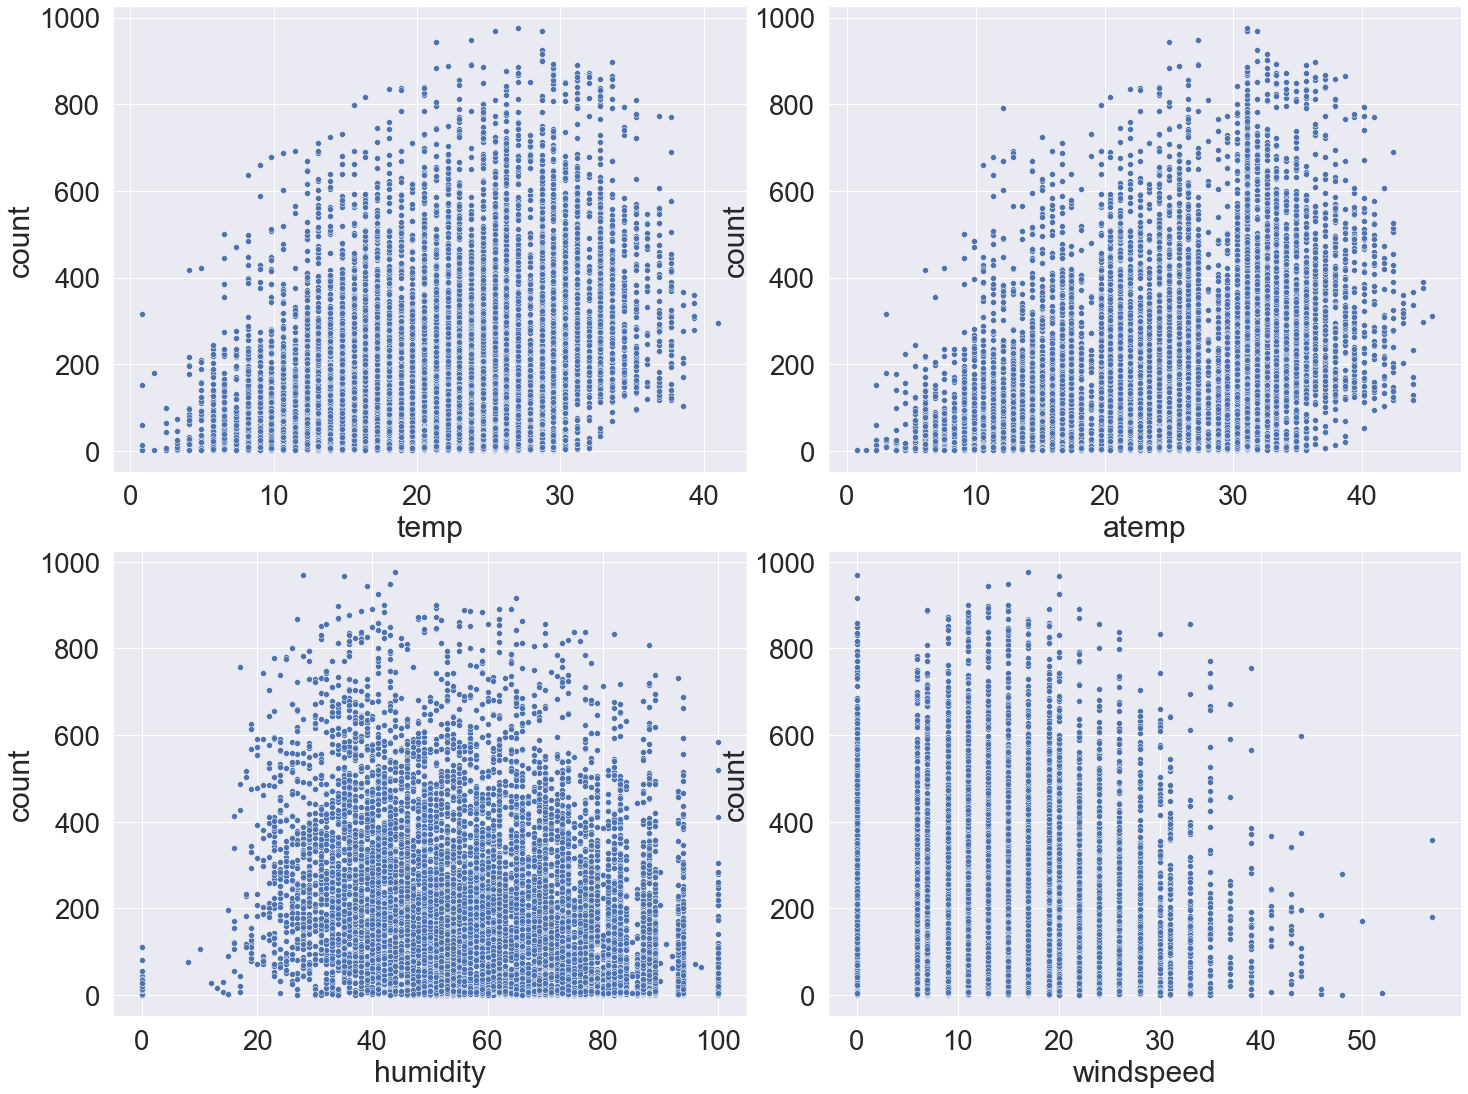

In [45]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15))

fig.tight_layout(h_pad=3)

sns.scatterplot(data=train_pdf2, x='temp', y='count', ax=ax[0][0])
sns.scatterplot(data=train_pdf2, x='atemp', y='count', ax=ax[0][1])
sns.scatterplot(data=train_pdf2, x='humidity', y='count', ax=ax[1][0])
sns.scatterplot(data=train_pdf2, x='windspeed', y='count', ax=ax[1][1])

## 상관관계
- count랑 전체 변수들간의 상관 관계는 거의 없음
- temp와 atemp와 상관관계는 너무 높음
- 나머지 humidity와 windspeed도 너무 상관관계가 없음

In [64]:
train_pdf2[['count', 'temp', 'atemp', 'humidity', 'windspeed']].corr()

,count,temp,atemp,humidity,windspeed
count,1.000000,0.394454,0.389784,-0.317371,0.101369
temp,0.394454,1.000000,0.984948,-0.064949,-0.017852
atemp,0.389784,0.984948,1.000000,-0.043536,-0.057473
humidity,-0.317371,-0.064949,-0.043536,1.000000,-0.318607
windspeed,0.101369,-0.017852,-0.057473,-0.318607,1.000000


<AxesSubplot:>

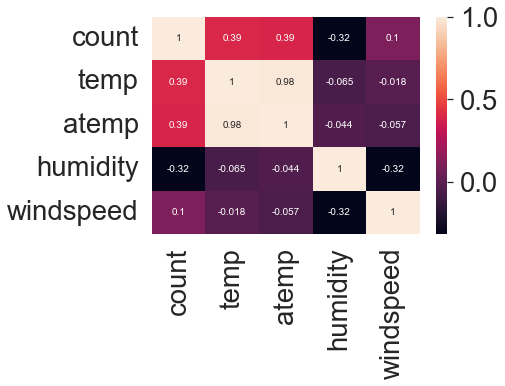

In [68]:

sns.heatmap(train_pdf2[['count', 'temp', 'atemp', 'humidity', 'windspeed']].corr(), annot=True)

## 다중공선성 확인

- temp랑 atemp가 아무래도 다중공선성을 띌 수도 있으니깐 이를 확인하는 법
- statsmodels.stats.outliners_influence import variance_inflation_factor를 통해서 확인할 수 있음
- 보면  'atemp', 'temp'가 값이 200이 넘어감. 'humidity'도 값이 10이 넘어감. 보통 10 이상의 점수를 받으면 feature가 다른 feature들과 굉장히 상관관계가 높음

In [81]:
import statsmodels.stats.outliers_influence
dir(statsmodels.stats.outliers_influence)

['Appender',
 'GLMInfluence',
 'MLEInfluence',
 'OLS',
 'OLSInfluence',
 '_BaseInfluenceMixin',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_plot_influence_doc',
 'cache_readonly',
 'defaultdict',
 'lzip',
 'maybe_unwrap_results',
 'multipletests',
 'np',
 'outlier_test',
 'reset_ramsey',
 'summary_table',
 'variance_inflation_factor']

In [82]:
train_pdf2.shape

(10886, 15)

In [84]:
# 각 columns마다 전체 row 데이터가 나옴
train_pdf2.values[:2]

array([[0.0, Timestamp('2011-01-01 00:00:00'), 14.395, 1, 81, 9.84, 1, 0,
        0, 16, 2011, 1, 1, 0, 5],
       [0.0, Timestamp('2011-01-01 01:00:00'), 13.635, 1, 80, 9.02, 1, 0,
        0, 40, 2011, 1, 1, 1, 5]], dtype=object)

atemp와 temp는 다중공선성 관계에 있음을 알 수 있다. (특히 위 그래프에서 확인)

In [85]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

tmp_train_pdf = train_pdf2[['weather', 'atemp', 'season', 'temp', 'windspeed','holiday', 'humidity', 'count' ]].copy()
vif = pd.DataFrame()

vif['vif factor'] = [ variance_inflation_factor(tmp_train_pdf.values, i) for i in range(tmp_train_pdf.shape[1])]
vif['features'] = tmp_train_pdf.columns

vif

,vif factor,features
0,7.286031,weather
1,290.420236,atemp
2,6.803422,season
3,263.839433,temp
4,2.984343,windspeed
5,1.030878,holiday
6,12.228869,humidity
7,2.800236,count


## 목적변수 확인

- 보면 0쪽에 데이터가 많이 몰려 있음

### 목적변수에 대한 왜도(Skewness)와 첨도(kurtosis)를 확인
- 왜도(Skewness, 비대칭도): 분포가 얼마나 비대칭을 띄는가 알려주는 척도 (a=0이면 정규분호, a<0 오른쪽으로 치우침, a>0 왼쪽으로 치우침) 
- 첨도(Kurtosis): 확률분포의 뾰족한 정도를 나타내는 척도 (관측치들이 어느 정도 집중적으로 줌ㅅ미에 몰려 있는가를 측정할때 사용됨)

skew:  1.2420662117180776
kurt:  1.3000929518398334


/Users/jmac/project/kaggle/bike_sharing_demand/venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='count', ylabel='Density'>

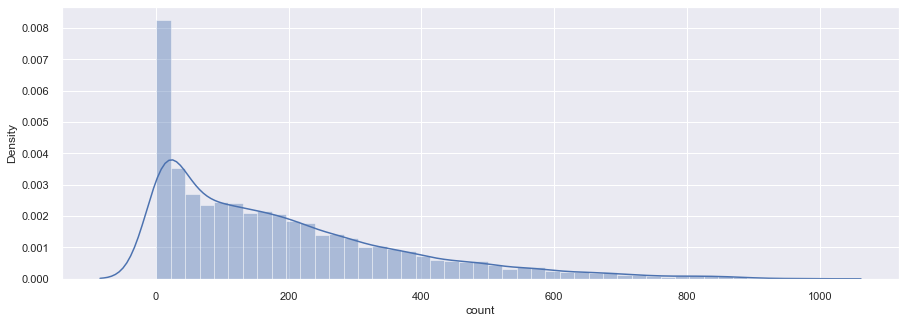

In [97]:
# print(dir(train_pdf2['count']))
print("skew: ", train_pdf2['count'].skew())
print("kurt: ", train_pdf2['count'].kurt())
# sns.set(rc = {'figure.figsize': (30,5)})
plt.figure(figsize=(15,5))
sns.distplot(train_pdf2['count'])

In [16]:
# 보면, 75%-max간에 차이가 커서 오른쪽으로 꼬리가 긴 그래프임을 알 수 있음
train_pdf2[['count']].describe()

,count
count,10886.000000
mean,191.574132
std,181.144454
min,1.000000
25%,42.000000
50%,145.000000
75%,284.000000
max,977.000000


### 목적변수 이상치 제거

- 방법은 3sigma나 IQR을 통해서 제거 가능

#### 3Sigma

원천에서 mean +- 3*std

In [26]:

count_mean, count_std = train_pdf2['count'].mean(), train_pdf2['count'].std()
print(f"count's mean : {count_mean}, std : {count_std}")
print(f"count's 3sigma {count_mean-3*count_std} ~ {count_mean+3*count_std}")

print(f"before {train_pdf2.shape}")
final_train_pdf = train_pdf2[train_pdf2['count']<count_mean+3*count_std].copy()
print(f"after {final_train_pdf.shape} -> removed {train_pdf2.shape[0]-final_train_pdf.shape[0]} outliers")

count's mean : 191.57413191254824, std : 181.14445383028527
count's 3sigma -351.8592295783075 ~ 735.0074934034039
before (10886, 10)
after (10739, 10) -> removed 147 outliers


In [27]:
final_train_pdf.tail()

,windspeed,workingday,temp,count,weather,atemp,holiday,datetime,season,humidity
10881,26.0027,1,15.58,336,1,19.695,0,2012-12-19 19:00:00,4,50
10882,15.0013,1,14.76,241,1,17.425,0,2012-12-19 20:00:00,4,57
10883,15.0013,1,13.94,168,1,15.910,0,2012-12-19 21:00:00,4,61
10884,6.0032,1,13.94,129,1,17.425,0,2012-12-19 22:00:00,4,61
10885,8.9981,1,13.12,88,1,16.665,0,2012-12-19 23:00:00,4,66


/Users/jmac/project/kaggle/bike_sharing_demand/venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jmac/project/kaggle/bike_sharing_demand/venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jmac/project/kaggle/bike_sharing_demand/venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt 

[Text(0.5, 1.0, 'apply log10 to after count')]

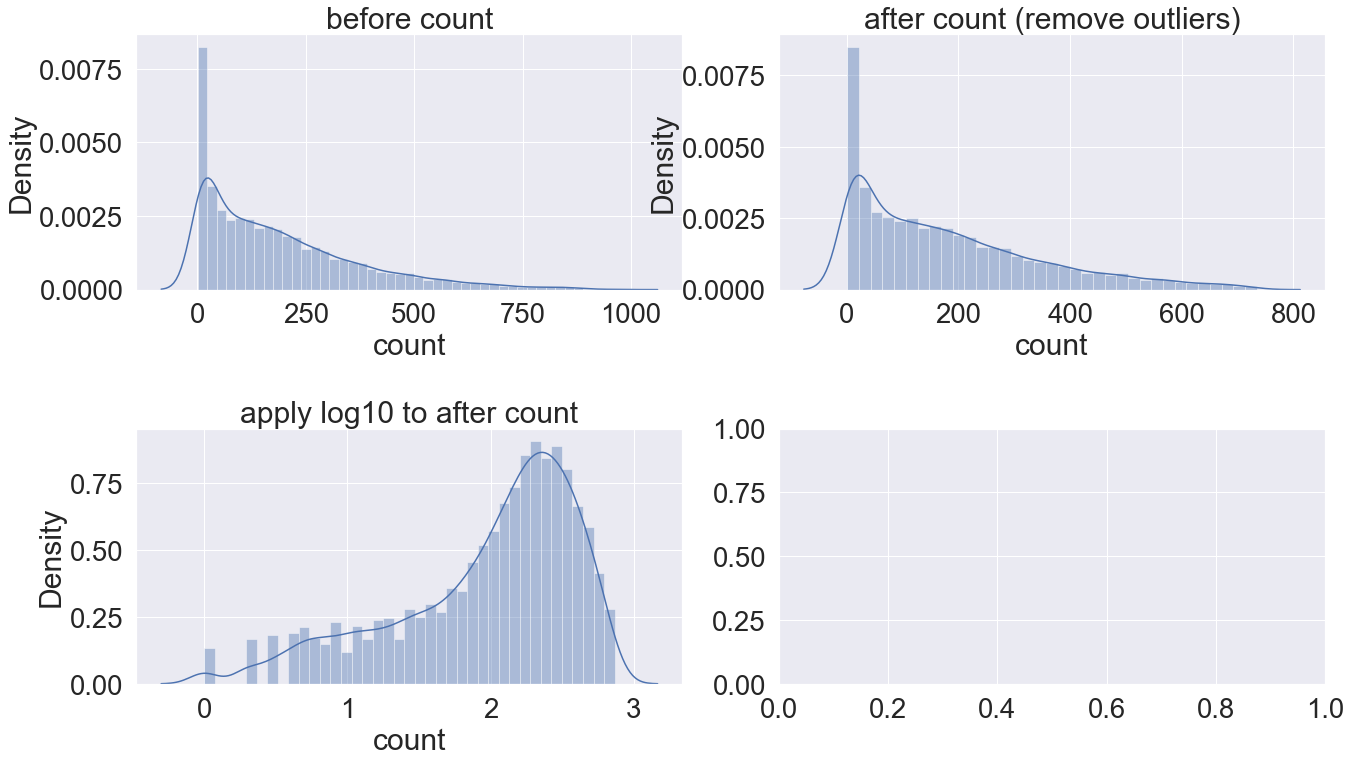

In [28]:
import numpy as np
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,10))
fig.tight_layout(h_pad=9)
sns.distplot(train_pdf2['count'], ax=ax[0][0])
sns.distplot(final_train_pdf['count'], ax=ax[0][1])
sns.distplot(np.log10(final_train_pdf['count']),ax=ax[1][0])

ax[0][0].set(title="before count")
ax[0][1].set(title="after count (remove outliers)")
ax[1][0].set(title="apply log10 to after count")

#### IQR
